In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import nivapy3 as nivapy
import folium
import shapely
import numpy as np
import matplotlib.pyplot as plt
from rasterstats import point_query

plt.style.use('ggplot')

# CROSSLINK stream profiles

This notebook explores options for deriving (i) stream profiles and (ii) buffered land use proportions for the CROSSLINK project. It's not a comprehensive analysis, just a proof-of-concept.

## 1. Datasets

### 1.1. Elevation

10 m and 1 m resolution elevation datasets are available from Kartverket's [Høydedata website](https://hoydedata.no/LaserInnsyn/). For the work here, I'll use the 1 m dataset for maximum detail. Two different elevation models are available:

 * **Digital terrain model (DTM)**. The earth surface *without* trees, buildings and other objects <br><br> 
 * **Digital overflatemodeller (DOM)**. A surface model i.e. including trees, buildings and other objects
 
For CROSSLINK, DTM-1 is the most appropriate dataset, but note that this still includes roads, bridges and some other man-made features, so it is *not* a representation of the natural surface in urban areas. I have previously downloaded and merged DTM-1 tiles for the Oslo area as part of the iResponse project, so I can use the same data here.

### 1.2. River network

There must be a complete and detailed river network for Oslo somewhere, but so far I haven't found it! I do have some high resolution data from NVE (also provided for iResponse), but this is based on flow accumulation/flood modelling using the DTM dataset mentioned above. Unfortunately, this shows "rivers" often following roads, because in urban areas roads focus drainage during heavy rainfall events. This isn't much use for CROSSLINK. 

The best data I have found so far is the [N50 dataset](https://kartkatalog.geonorge.no/metadata/kartverket/n50-kartdata/ea192681-d039-42ec-b1bc-f3ce04c189ac) from Kartverket. This is the same stream data used on Norway's standard 1:50k map series. Unfortunately, there is a slight mismatch between the DTM dataset and the N50 streams, which results in very weird-looking stream profiles if used directly. The N50 data also only shows streams visible at the surface i.e. the lines are broken wherever a stream enters a culvert, and they're also broken between lake inflows and outflows. In order to derive sensible stream profiles, we need continuous lines for the entire river reaches of interest.

For the work in this notebook, I have manually digitised a new stream dataset using the N50 data as a guide, but being careful to follow valleys in the DTM-1 dataset as far as possible. I have also tried to join the line segments across lakes and culverts in a sensible way. So far, I have only done this for stream segments **in-between CROSSLINK monitoring sites**. If we need to extend the analysis to cover areas upstream, then more manual digitising will be required. This will be time-consuming, but could maybe be tackled by students, as previously discussed.

### 1.3. Land cover

Various land cover/land use datasets are available for the Oslo region - see the Excel summary previously compiled for CROSSLINK here:

    .\CROSSLINK\crosslink_norway_data_sources.xlsx
    
One possible option is [NIBIO Kilden](https://kilden.nibio.no), which has data from CORINE. However, perhaps the best general purpose land cover dataset I've found so far is the N50 `'ArealdekkeFlate'` layer. This matches nicely with the N50 river network (described above) and it's what I'll use here for testing.

## 2. Stream profiles

Benjamin has provided co-ordinates for the CROSSLINK monitoring sites (see e-mail recieved 26.02.2019 at 16.36), but I don't currently have unique site names/codes for each location. It will be easy to add these later, but for now I've simply assigned my own river and site codes, as follows:

 * River reaches are labelled A to J from west to east <br><br> 
 * Sites are numbered downstream from 1 to n along each river reach
 
For example, site A2 corresponds to the second station downstream along the westernmost CROSSLINK river (see map below for details).

**Note:** Just from looking at the points on a map, it is not always obvious how stations and reaches should be grouped. I can fix this once I have more information on the CROSSLINK sites, but for this notebook I'll just focus on streams where the groupings are pretty obvious.

### 2.1. Map of sites and streams

The map below plots the CROSSLINK stations together with my manually digitised rivers. The map is interactive: clicking on a station will show a popup with my (temporary) station codes (A1, etc.), and clicking on the layer control button (top-right) makes it possible to turn layers on/off and to switch between different basemaps. The basemaps are useful for checking riparian vegetation, man-made features etc.

In [2]:
# Paths to data
riv_shp = r'../../gis/vector/crosslink_rivers_between_sites.shp'
sites_shp = r'../../gis/vector/crosslink_sites.shp'

# Read shapefiles
riv_gdf = gpd.read_file(riv_shp)
sites_gdf = gpd.read_file(sites_shp)

# Convert to WGS84 json
riv_gdf = riv_gdf.to_crs(epsg='4326')
riv_json = riv_gdf.to_json()

sites_gdf = sites_gdf.to_crs(epsg='4326')
sites_json = sites_gdf.to_json()

# Basic map
m = folium.Map(location=[65, 10], 
               zoom_start=4,
               tiles='Stamen Terrain')

# Add openstreetmap
folium.TileLayer('openstreetmap').add_to(m)

# Add satellite imagery
folium.raster_layers.TileLayer(tiles='http://{s}.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
                               attr='google',
                               name='Google satellite',
                               max_zoom=20,
                               subdomains=['mt0', 'mt1', 'mt2', 'mt3'],
                               overlay=False,
                               control=True).add_to(m)

# Add rivers
m.choropleth(geo_data=riv_json, line_weight=3, line_color='blue', name='Rivers')

# Add feature group to map
grp = folium.FeatureGroup(name='Stations')

# Add points, with site code popup
for idx, row in sites_gdf.iterrows():
    marker = folium.CircleMarker(location=[row['lat'], row['lon']],
                                 radius=5,
                                 weight=1,
                                 color='black',
                                 popup=folium.Popup(row['site_code'], parse_html=False),
                                 fill_color='red',
                                 fill_opacity=1)
    grp.add_child(marker)
grp.add_to(m)

# Add layer control
folium.LayerControl().add_to(m)
    
# Zoom to data
xmin, xmax = riv_gdf.bounds['minx'].min(), riv_gdf.bounds['maxx'].max()
ymin, ymax = riv_gdf.bounds['miny'].min(), riv_gdf.bounds['maxy'].max()
m.fit_bounds([[ymin, xmin], [ymax, xmax]])

m

### 2.2. Estimate profile elevations

**Note:** The code below makes use of the [rasterstats](https://github.com/perrygeo/python-rasterstats) package, which can be installed in the DSToolkit using `'pip install rasterstats'`.

For this test, I'm going to focus on rivers where the groupings of sites are pretty obvious (i.e. where there are no tributaries). This means **rivers A, B, H and J** from the map above.

Note also that, due to urban infrastructure (roads, bridges, culverts etc.), there are many cases where the rivers seem to flow uphill for short periods. This creates unrealistic profiles, but there's not much I can do given the data currently available. One rough solution is to calculate a smoothed version of the profile using a rolling window. In the code below, I've defined a `'step_size'` (in metres) that controls the frequency at which elevations are sampled, and a smoothing window (`'win'`) that determines the number of steps included a centred, rectangular moving window over which **median elevations** are calculated. This median moving window removes some of the topographic noise and creates more plausible profiles, but at the cost of some loss of detail.

In [3]:
# User settings

# Rivers of interest
riv_list = ['A', 'B', 'H', 'J']

# Spacing for sampling profile elevations
step_size = 10

# Smoothing window
win = 20

# Data paths 
dtm_path = r'../../gis/raster/oslo_1m_dtm_utmz33_clip.tif'
riv_shp = r'../../gis/vector/crosslink_rivers_between_sites.shp'
sites_shp = r'../../gis/vector/crosslink_sites.shp'

In [4]:
# Read rivers and sites. Project to EPSG 25833
riv_gdf = gpd.read_file(riv_shp).to_crs(epsg='25833')
sites_gdf = gpd.read_file(sites_shp).to_crs(epsg='25833')

# Extract riv_code from site_code
sites_gdf['riv_code'] = sites_gdf['site_code'].str[0]

# Dict for results
data_dict = {}

# Loop over rivers
for riv in riv_list:
    print ('Processing river %s...' % riv)
    
    # Get data for this river
    riv_line = riv_gdf.query('riv_code == @riv')
    
    # Get line length
    riv_len = riv_line['geometry'].length.values[0]

    # Get line intervals
    steps = range(0, int(riv_len), step_size)

    # Dict for this profile
    prof_dict = {'dist':[],
                 'elev_m':[],
                 'pts':[]}

    # Step along line
    for step in steps:
        # Get point and elev
        pt = riv_line['geometry'].iloc[0].interpolate(step)
        elev = point_query(pt.wkt, dtm_path)[0]

        # Append to results
        prof_dict['dist'].append(step)
        prof_dict['elev_m'].append(elev)
        prof_dict['pts'].append(pt)

    # Results dataframe for this profile
    df = pd.DataFrame(prof_dict)
    
    # Add to overall results
    data_dict[riv] = df
    
print ('Finished.')

Processing river A...
Processing river B...
Processing river H...
Processing river J...
Finished.


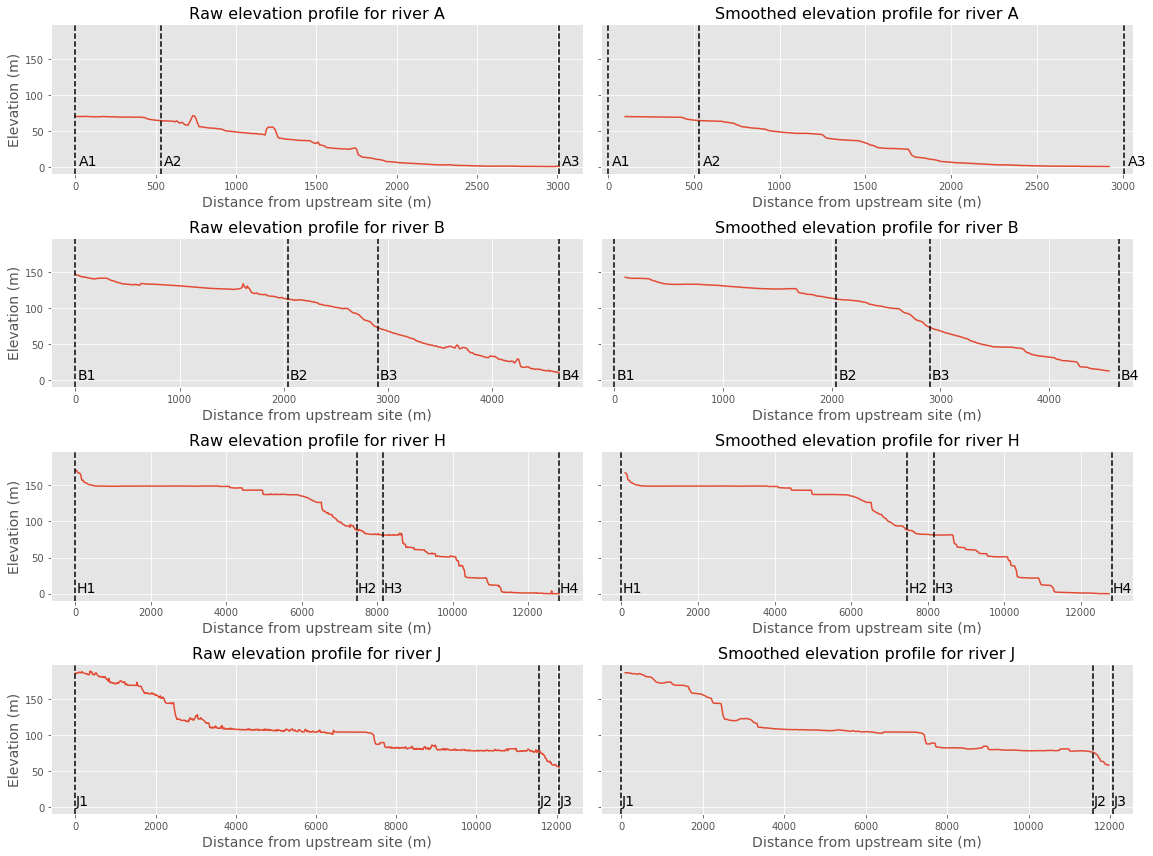

In [5]:
# Setup plot
fig, axes = plt.subplots(nrows=len(riv_list), 
                         ncols=2, 
                         figsize=(16, 3*len(riv_list)),
                         sharex=False,
                         sharey=True)

# Loop over rivers
for idx, riv in enumerate(riv_list):
    # Get data
    df = data_dict[riv].copy()
    df.set_index('dist', inplace=True) 
    
    # Apply rolling median
    df['median_elev_m'] = df[['elev_m']].rolling(window=win, center=True).median()
    
    # Plot raw profile
    df[['elev_m']].plot(ax=axes[idx, 0], legend=False)
    
    # Plot smoothed profile
    df[['median_elev_m']].plot(ax=axes[idx, 1], legend=False)
    
    # Get stations along this river
    riv_stns = sites_gdf.query('riv_code == @riv')
    
    # Loop over stations
    for ridx, row in riv_stns.iterrows():
        # Get station location
        site_loc = row['geometry']
        name = row['site_code']
        site_loc.wkt
        
        # Get list of all profile points 
        pts = df['pts'].values
        
        # Find distance of nearest profile point to station
        prof_dist = df.index.values[np.argmin([site_loc.distance(pt) for pt in pts])]
        
        # Add vertical lines to plot
        axes[idx, 0].axvline(prof_dist, c='k', ls='--')
        axes[idx, 1].axvline(prof_dist, c='k', ls='--')
        
        # Labels
        axes[idx, 0].text(prof_dist+20, 2, name, fontsize=14)
        axes[idx, 1].text(prof_dist+20, 2, name, fontsize=14)
        
        axes[idx, 0].set_xlabel('Distance from upstream site (m)', fontsize=14)
        axes[idx, 1].set_xlabel('Distance from upstream site (m)', fontsize=14)
        
        axes[idx, 0].set_ylabel('Elevation (m)', fontsize=14)
        axes[idx, 1].set_ylabel('Elevation (m)', fontsize=14)
        
        axes[idx, 0].set_title('Raw elevation profile for river %s' % riv, fontsize=16)        
        axes[idx, 1].set_title('Smoothed elevation profile for river %s' % riv, fontsize=16)

plt.tight_layout()

## 3. Land cover

The code below buffers the rivers by a user-specified distance and then intersects the buffers with the N50 land cover dataset. Summary land cover areas are then calculated for each stream segment.

**Note:** The code below only considers the manually digitised stream segments shown on the map in section 2.1. If we need to consider river reaches further upstream, we'll need to do more manual digitising.

The table at the end of this section shows land cover areas **in hectares** for a 50 m buffer either side of each stream segment.

In [6]:
# User input

# Buffer distance (metres)
buff_dist = 50

# File paths
riv_shp = r'../../gis/vector/crosslink_rivers_between_sites.shp'
lc_shp = r'../../gis/vector/N_1to50k_Land_Cover_Polys_Oslo.shp'

In [7]:
# Read data and reproject
riv_gdf = gpd.read_file(riv_shp).to_crs(epsg='25833')
lc_gdf = gpd.read_file(lc_shp).to_crs(epsg='25833')

# Get just land cover cols
lc_gdf = lc_gdf[['geometry', 'OBJTYPE']]
lc_gdf.columns = ['geometry', 'land_cover']

# Buffer streams (and convert to lines -> polygons)
riv_gdf['geometry'] = riv_gdf['geometry'].buffer(buff_dist)

# Compute spatial intersection
buff_gdf = gpd.overlay(riv_gdf, lc_gdf, how='intersection')

# Group by river reach and land cover class
buff_gdf = buff_gdf.dissolve(by=['riv_code', 'land_cover'])

# Calc class areas in km2
buff_gdf['area_km2'] = buff_gdf['geometry'].area / (10**6)

# Pivot
del buff_gdf['geometry'], buff_gdf['Id']
lc_df = buff_gdf.unstack(level='land_cover')

# Fill NaN with 0
lc_df.fillna(0, inplace=True)

# Display results in ha
lc_df*100

area_km2                                                 \
land_cover BymessigBebyggelse DyrketMark   ElvBekk Industriområde     Innsjø   
riv_code                                                                       
A                    0.000000   1.506465  0.000000       0.000000   0.000000   
B                    0.000000   0.567545  0.000000       0.000000   0.000000   
C                    0.000000   0.000000  0.000000       0.000000   0.000000   
D                    0.000000   0.000000  0.000000       0.000000   0.000000   
E                    0.000000   0.000000  0.000000       0.000000   3.842312   
F                    0.429894   8.127736  0.000000       0.000000   1.901315   
G                    0.000000   0.000000  0.000000       0.000000   0.000000   
H                    5.165121   0.000000  9.262421       4.070889  34.722999   
I                    0.000000   0.000000  0.000000       0.465743   0.000000   
J                    0.000000   0.000000  0.000000      12.622326   0.000000   

                                                                               \
land_cover InnsjøRegulert     Park       Skog SportIdrettPlass Tettbebyggelse   
riv_code                                                                        
A                0.000000  0.00000  15.773732         0.000000      12.314212   
B                0.000000  0.00000  23.445692         0.000000      14.954472   
C                0.000000  0.00000   5.795101         0.000000       3.400015   
D                0.000000  0.00000   9.724425         0.000000       4.343880   
E                0.000000  0.00000  12.813922         0.000000      23.306722   
F               10.002723  5.48365  23.388927         0.262584      10.988657   
G                0.000000  0.00000   0.000000         0.000000       3.708513   
H                0.000000  0.00000  17.705914         0.000000       4.990738   
I                0.000000  0.00000   2.891026         0.000000      14.536571   
J                0.000000  0.00000  39.920079         0.000000       4.590102   

                        
land_cover ÅpentOmråde  
riv_code                
A             0.995198  
B             7.699543  
C             8.525930  
D             0.000000  
E             4.909963  
F            17.602318  
G             0.349980  
H            52.392347  
I             7.107153  
J            61.564121